## Northwind Dataset Analysis - May 2019

Using the Northwind database, an open-source dataset created by Microsoft, this Jupyter notebook will do some exploratory data analysis and use hypothesis testing to dive deep into four questions:
1. Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?
2. Do discounts have a statistically significant effect on the dollar value of orders?
3. Do customers with longer order histories make larger value orders?
4. Do customers with longer order histories order more frequently?


Step 1: Import the libraries used.

In [1]:
#imports
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
%matplotlib inline

from math import sqrt
import scipy.stats as stats
from sklearn import preprocessing

from datetime import datetime
# import warnings
# warnings.filterwarnings("ignore")

Step 2: Create an sqalchemy "engine" to query the database tables.

In [2]:
# create the SQL engine
# optinal - to use the large version of the databse, use this to create the SQL engine:
# engine = create_engine('sqlite:///Northwind_large.sqlite', echo=True)

# using the small version of the databse:
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
con = engine.connect()
Session = sessionmaker(bind=engine)
session = Session()

2019-05-17 12:00:18,049 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-17 12:00:18,051 INFO sqlalchemy.engine.base.Engine ()
2019-05-17 12:00:18,052 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-17 12:00:18,054 INFO sqlalchemy.engine.base.Engine ()


In [3]:
# have a look at the various tables
inspector = inspect(engine)
print(inspector.get_table_names())

2019-05-17 12:00:18,062 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-05-17 12:00:18,064 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


There are 13 tables. This chart shows the relationships between the tables.
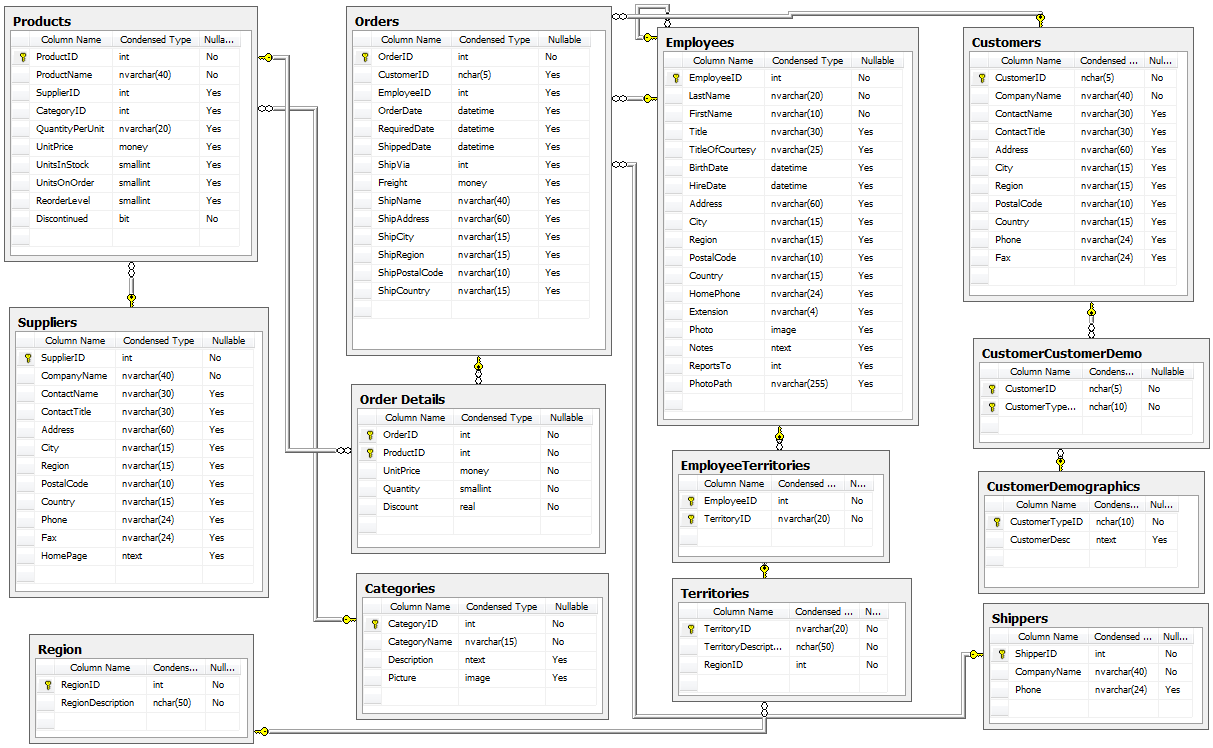

As I will be creating multiple pandas dataframes from the sql tables, I need a function that will return the column names from an SQL table.

In [5]:
#function to return a list of the column names from table given as an argument
def make_column_list(table):
    cols = []  #make an empty list
    cols_dict = inspector.get_columns(table)  # make a dict of the column names from the SQL table
#     print(cols_list)
    for column in cols_dict:
        cols.append(column['name'])
#     print(cols)
    return cols

In [6]:
# crate a pandas dataframe of the OrderDetail table
rs = con.execute('SELECT * FROM OrderDetail')
order_detail = pd.DataFrame(rs.fetchall())

column_names = make_column_list('OrderDetail')
order_detail.columns = column_names

order_detail.head()

2019-05-17 12:00:18,089 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail
2019-05-17 12:00:18,091 INFO sqlalchemy.engine.base.Engine ()
2019-05-17 12:00:18,101 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-05-17 12:00:18,102 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [7]:
# customer table to a pandas dataframe
rs = con.execute('SELECT * FROM Customer')
customers = pd.DataFrame(rs.fetchall())
column_names = make_column_list('Customer')
customers.columns = column_names

customers.head(10)

2019-05-17 12:00:18,128 INFO sqlalchemy.engine.base.Engine SELECT * FROM Customer
2019-05-17 12:00:18,130 INFO sqlalchemy.engine.base.Engine ()
2019-05-17 12:00:18,134 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-05-17 12:00:18,135 INFO sqlalchemy.engine.base.Engine ()


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67
5,BLAUS,Blauer See Delikatessen,Hanna Moos,Sales Representative,Forsterstr. 57,Mannheim,Western Europe,68306,Germany,0621-08460,0621-08924
6,BLONP,Blondesddsl père et fils,Frédérique Citeaux,Marketing Manager,"24, place Kléber",Strasbourg,Western Europe,67000,France,88.60.15.31,88.60.15.32
7,BOLID,Bólido Comidas preparadas,Martín Sommer,Owner,"C/ Araquil, 67",Madrid,Southern Europe,28023,Spain,(91) 555 22 82,(91) 555 91 99
8,BONAP,Bon app,Laurence Lebihan,Owner,"12, rue des Bouchers",Marseille,Western Europe,13008,France,91.24.45.40,91.24.45.41
9,BOTTM,Bottom-Dollar Markets,Elizabeth Lincoln,Accounting Manager,23 Tsawassen Blvd.,Tsawassen,North America,T2F 8M4,Canada,(604) 555-4729,(604) 555-3745


In [8]:
# orders table to pandas datafarame
rs = con.execute('SELECT * FROM [Order]')
orders = pd.DataFrame(rs.fetchall())

column_names = make_column_list('Order')
orders.columns = column_names

orders.head()

2019-05-17 12:00:18,155 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-05-17 12:00:18,157 INFO sqlalchemy.engine.base.Engine ()
2019-05-17 12:00:18,166 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-05-17 12:00:18,168 INFO sqlalchemy.engine.base.Engine ()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


After some errors during EDA I discovered some orders with CustomerId's that did not exist in the Customers table:
* ANTO
* DUMO
* OCEA
* QUEE

Upon inspection of the Customers table, it appears that the above Id's are all missing an "N" at the end of the Id. As customer Id's have 5 letters except these 4, so I chose to assign these orders to the what reasonably appears to be the correct Customer, assuming that the last letter had somehow been deleted. 

In [9]:
# correct the incorect CustomerId values in orders_count
orders['CustomerId'].replace('ANTO', 'ANTON', inplace=True)
orders['CustomerId'].replace('DUMO', 'DUMON', inplace=True)
orders['CustomerId'].replace('OCEA', 'OCEAN', inplace=True)
orders['CustomerId'].replace('QUEE', 'QUEEN', inplace=True)
orders.sort_values('CustomerId').groupby('CustomerId').groups

{'ALFKI': Int64Index([763, 444, 454, 587, 704, 395], dtype='int64'),
 'ANATR': Int64Index([511, 678, 377, 60], dtype='int64'),
 'ANTON': Int64Index([608, 117, 287, 325, 259, 434, 429], dtype='int64'),
 'AROUT': Int64Index([135, 520, 205, 616, 495, 310, 493, 459, 705, 768, 107, 672, 545], dtype='int64'),
 'BERGS': Int64Index([627, 406, 618, 676, 441, 485, 424, 378, 530, 609,  32, 276, 324,
              30, 197, 136, 196, 589],
            dtype='int64'),
 'BLAUS': Int64Index([366, 708, 261, 605, 334, 810, 253], dtype='int64'),
 'BLONP': Int64Index([112, 578, 49, 17, 311, 318, 336, 431, 201, 380, 188], dtype='int64'),
 'BOLID': Int64Index([78, 553, 722], dtype='int64'),
 'BONAP': Int64Index([ 83, 222, 692, 828,  92, 263, 114, 684, 415, 277, 579, 507, 484,
             623, 628, 467, 482],
            dtype='int64'),
 'BOTTM': Int64Index([162, 701, 696, 670, 800, 244, 494, 183, 727, 797, 734, 163, 779,
             141],
            dtype='int64'),
 'BSBEV': Int64Index([291, 290, 699, 23

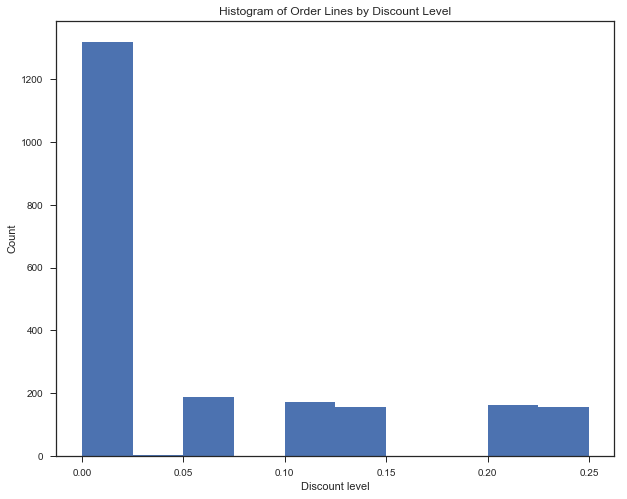

In [10]:
# an initial look at how product line items in the orders are distributed based on any discounts
fig, ax = plt.subplots(figsize=(10, 8))
plt.hist(order_detail["Discount"])
ax.set_xlabel('Discount level')
ax.set_ylabel('Count')
ax.set_title('Histogram of Order Lines by Discount Level')
plt.show()

The vast majority of products ordered have no discount.
For ordered products that had a discount applied, the distribution into different levels of discount looks roughly equal.

The order_detail dataframe does not have any totals so I created a total for each line as that value would appear on the actual order.

In [11]:
# make a new column to calculate the line item total
order_detail['line_total'] = order_detail['Quantity'] * order_detail['UnitPrice'] * (1 - order_detail['Discount'])

order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [12]:
# a little more EDA, how many orders had at least one product discounted?
rs = con.execute('SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0')

orders_with_discount = pd.DataFrame(rs.fetchall())

orders_with_discount.columns = ['Id']

orders_with_discount.count()

2019-05-17 12:00:18,647 INFO sqlalchemy.engine.base.Engine SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0
2019-05-17 12:00:18,650 INFO sqlalchemy.engine.base.Engine ()


Id    380
dtype: int64

380 orders had at least one discounted product. How many orders had no discounts?

In [13]:
# make a list of orders that have no discounted items
orders_without_discount = orders.merge(orders_with_discount.drop_duplicates(), on=['Id'], how='left', indicator=True)

orders_without_discount = orders_without_discount[orders_without_discount._merge != 'both']

orders_without_discount.count()

Id                450
CustomerId        450
EmployeeId        450
OrderDate         450
RequiredDate      450
ShippedDate       440
ShipVia           450
Freight           450
ShipName          450
ShipAddress       450
ShipCity          450
ShipRegion        450
ShipPostalCode    446
ShipCountry       450
_merge            450
dtype: int64

450 orders had no discounted items. Just to check the totals, I checked the total number of orders.

In [14]:
len(orders)

830

450 orders with no discount plus 380 orders that had a discount equals 830 total orders. Now checking for any missing values in the orders table. 

In [15]:
orders.count()

Id                830
CustomerId        830
EmployeeId        830
OrderDate         830
RequiredDate      830
ShippedDate       809
ShipVia           830
Freight           830
ShipName          830
ShipAddress       830
ShipCity          830
ShipRegion        830
ShipPostalCode    811
ShipCountry       830
dtype: int64

* 19 orders have no value for ShipPostalCode.
* 21 orders have no value for ShippedDate.

To investigate the first question:

**_Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?_**

I added four new columns to the orders table:
* order_total
* unique_products_count
* all_items_total_qty_count
* discount_flag


In [16]:
# add blank columns to orders dataframe
orders['order_total'] = 0
orders['unique_products_count'] = 0
orders['all_items_total_qty_count'] = 0
orders['discount_flag'] = False #True if order contains any discounted items, otherwise False

orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,0,0,0,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,0,0,0,False
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,0,0,0,False
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,0,0,0,False
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,0,0,0,False


In [17]:
# populate the new columns

for index, row in orders.iterrows():
    order_id = row['Id']     #row['Id'] gets the OrderId column value
    order_index = index
    
# get the relevant rows from order_detail
    temp_df = order_detail.loc[order_detail['OrderId'] == order_id]
    
    #clear the variables
    order_total = 0
    order_product_ids_count = 0
    product_ids = []
    all_items_total_qty_count = 0
    discount_flag = False
    
    # iterate through the order_detail rows and calculate the values
    for index, row in temp_df.iterrows():
        order_total += round((row['UnitPrice'] * row['Quantity']) * (1 - row['Discount']),2)
        product_ids.append(row['ProductId'])  #get the unique product id's
        all_items_total_qty_count += row['Quantity'] #count up the total # of units of all products in the order

    #check if any discount, if yes skip for this row, otherwise check if the current row has a discount
        if discount_flag == False:
            if row['Discount'] > 0:
                discount_flag = True
    
    product_ids = set(product_ids)     #make a set (unique values only) of the product id's
    
# add these values to the order in the orders dataframe
    orders.iloc[order_index, orders.columns.get_loc('order_total')] = order_total
    orders.iloc[order_index, orders.columns.get_loc('unique_products_count')] = len(product_ids)
    orders.iloc[order_index, orders.columns.get_loc('all_items_total_qty_count')] = all_items_total_qty_count
    orders.iloc[order_index, orders.columns.get_loc('discount_flag')] = discount_flag


In [18]:
orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,440.00,3,27,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,1863.40,2,49,False
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,1552.60,3,60,True
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,654.06,3,41,True
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,3597.90,3,105,True


I then split the orders table into two tables, one for orders with a discount and one for orders without a discount and checked to make sure the length of the tables matched the original SQL tables.


In [19]:
discount = orders[orders['discount_flag'] == True].copy()
len(discount)

380

In [20]:
no_discount = orders[orders['discount_flag'] == False].copy()
len(no_discount)

450

I wanted to first look at a scatter plot comparing orders with and without a discount.

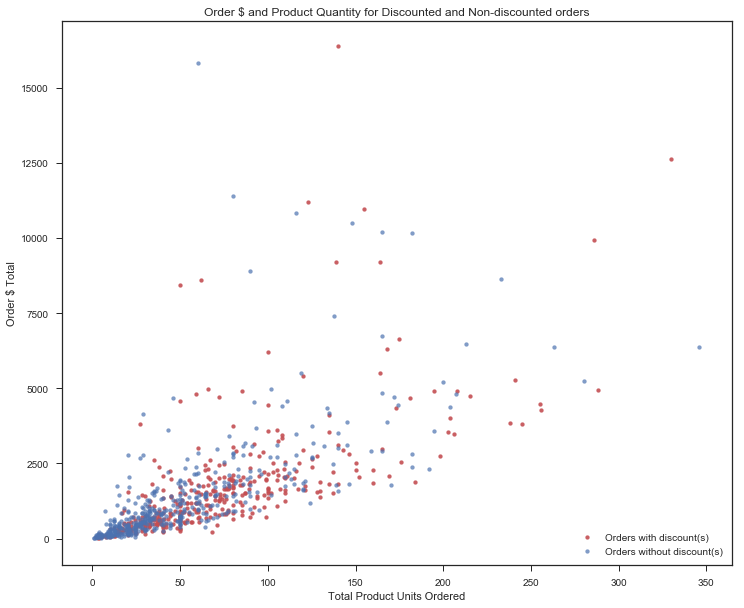

In [21]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(discount['all_items_total_qty_count'], discount['order_total'], s=15, c='r', alpha=.9, label='Orders with discount(s)')
ax.scatter(no_discount['all_items_total_qty_count'], no_discount['order_total'], s=15, c='b', alpha=.7, label='Orders without discount(s)')
ax.set_xlabel("Total Product Units Ordered")
ax.set_ylabel("Order $ Total")
ax.set_title('Order $ and Product Quantity for Discounted and Non-discounted orders')
plt.legend(loc='lower right')

There does appear to be a relationship where orders wtih a discount tend to have a higher total units ordered. To investigate further, I need to look at the level of discount present. To do this I will need to look at the order_details table.

In [22]:
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


Assign each product line item to one of four discount groups:
* 1 = discount less than 5% or no discount
* 2 = discount equal to or greater than 5% but less than 10%
* 3 = discount equal to or greater than 10% but less than 20%
* 4 = discount equal to or greater than 20%

In [23]:
#create the new column and fill it with zero's
order_detail['discount_group'] = 0

#iterate through the dataframe and assign each line to the correct group
for index, row in order_detail.iterrows():
#     x = order_detail.columns.get_loc('discount_group')
#     print(x)
#     break
    if row['Discount'] < 0.05:
        order_detail.iloc[index, 7] = 1
    if row['Discount'] >= 0.05 and row['Discount'] < 0.10:
        order_detail.iloc[index, 7] = 2
    if row['Discount'] >= .1 and row['Discount'] < 0.2:
        order_detail.iloc[index, 7] = 3
    if row['Discount'] >= 0.2:
        order_detail.iloc[index, 7] = 4


In [24]:
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total,discount_group
0,10248/11,10248,11,14.0,12,0.0,168.0,1
1,10248/42,10248,42,9.8,10,0.0,98.0,1
2,10248/72,10248,72,34.8,5,0.0,174.0,1
3,10249/14,10249,14,18.6,9,0.0,167.4,1
4,10249/51,10249,51,42.4,40,0.0,1696.0,1


In [25]:
# look at the average quantity of product for each level of discount
grouped_temp = order_detail.groupby('discount_group')

grouped_quantity = pd.DataFrame(grouped_temp['Quantity'].agg(np.mean))
grouped_quantity.reset_index(inplace=True)
grouped_quantity

,discount_group,Quantity
0,1,21.609517
1,2,27.870968
2,3,26.733333
3,4,27.619048


It appears that orders with a discount have a significantly higher mean quantity ordered than orders with a discount less than 5%


In [26]:
grouped_line_total = pd.DataFrame(grouped_temp['line_total'].agg(np.mean))
grouped_line_total.reset_index(inplace=True)
grouped_line_total

,discount_group,line_total
0,1,567.210544
1,2,793.985454
2,3,542.440342
3,4,597.205306


* Orders with discounts from 5-9% have a substantially higher average dollar value than orders with discounts less than 5%.
* Orders with discounts from 10-19% have slightly lower average dollar value than orders with discounts less than 5%.
* Orders with discounts greater than 19% have slightly higher average dollar value than orders with discounts less than 5%.


In [27]:
# make discount_group a categorical daya type in the order_detail table
order_detail['discount_group'] = pd.Categorical(order_detail['discount_group'])
print (order_detail.dtypes)

Id                  object
OrderId              int64
ProductId            int64
UnitPrice          float64
Quantity             int64
Discount           float64
line_total         float64
discount_group    category
dtype: object


Text(0, 0.5, 'Mean Quantity of Product Ordered')

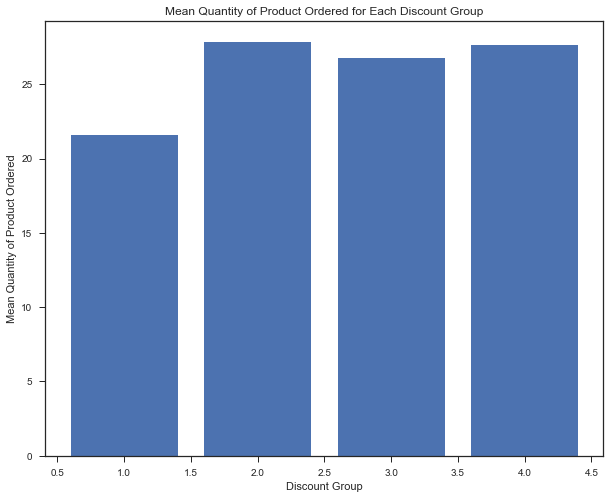

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.bar(x='discount_group', height='Quantity', data = grouped_quantity, align='center')
ax.set_title('Mean Quantity of Product Ordered for Each Discount Group')
ax.set_xlabel('Discount Group')
ax.set_ylabel('Mean Quantity of Product Ordered')


The average quantity ordered appears to be similarly higher for each category of discount, as compared to products with a less than 5% discount.

Text(0, 0.5, 'Mean Order Line Total')

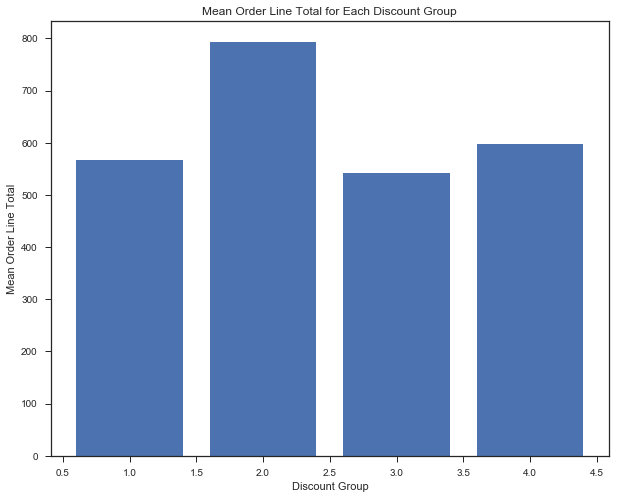

In [29]:
# bar chart of line_total by discount_category
fig, ax = plt.subplots(figsize=(10, 8))
plt.bar(x='discount_group', height='line_total', data = grouped_line_total, align='center')
ax.set_title('Mean Order Line Total for Each Discount Group')
ax.set_xlabel('Discount Group')
ax.set_ylabel('Mean Order Line Total')


It looks like products ordered with a discount_category of 2 generate the largest mean dollar amount.

Discount category 2 = discounts of at least 5% but less than 10%.

## Hypothesis test 1:

### Ho: There is no difference in the mean quantity ordered of products with a discount of 5% or more as compared to products ordered with a discount of less than 5%.

### Ha: The mean quantity of products ordered with a discount of 5% or more is higher than products ordered with a discount of less than 5%.

In [30]:
# calculate the mean quantity ordered when a discount of at least 5% is present
mean_with_discount = np.mean(order_detail[order_detail['Discount'] >= 0.05]['Quantity'])
mean_with_discount

27.323706377858002

In [31]:
# get the number of rows that have a discount of 5% or greater
len(order_detail[order_detail['Discount'] >= 0.05])


831

In [32]:
# calculate the mean quantity ordered when the discount is less than 5%

mean_without_discount = np.mean(order_detail[order_detail['Discount'] < 0.05]['Quantity'])
mean_without_discount

21.6095166163142

In [33]:
# get the numer of rows that have a discount less than 5%
len(order_detail[order_detail['Discount'] < 0.05])

1324

In [34]:
# check the total of records in order_detail to confirm I have split the data correctly
len(order_detail)

2155

In [35]:
# calculate the actual difference in the mean quantity ordered between the two groups
actual_difference = mean_with_discount - mean_without_discount
actual_difference

5.714189761543803

In [36]:
# this funcion takes in a dataframe, the number of times to pull a random sample, 
# the size of each sample, and the name of the column in the datafram to pull the sample from
# for each trial the function pulls a random sample from the dataframe as the "treatment" group
# and pulls the remaining values from the dataframe as the "control" group.
# the difference in the mean between these two groups is calculated (treatment - control) 
# and stored in a list. 
# The final list returned by the function represents the differences in mean from 
# all trials.

def permutation_samples(key_value_list, no_of_trials, sample_size, column):
    difference_of_means = []
    np.random.seed(3)

    while len(difference_of_means) < no_of_trials:
        temp_keys = key_value_list.index.values
        treatment_keys = np.random.choice(temp_keys, sample_size, replace=False)

        treatment = key_value_list[key_value_list.index.isin(treatment_keys)]
        control = key_value_list[~key_value_list.index.isin(treatment_keys)]

        # actual difference, positive or negative
        difference = np.mean(treatment[column]) -  np.mean(control[column])
        difference_of_means.append(difference)

#         print('difference value added:', abs_difference)
    return(difference_of_means)

/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Frequency')

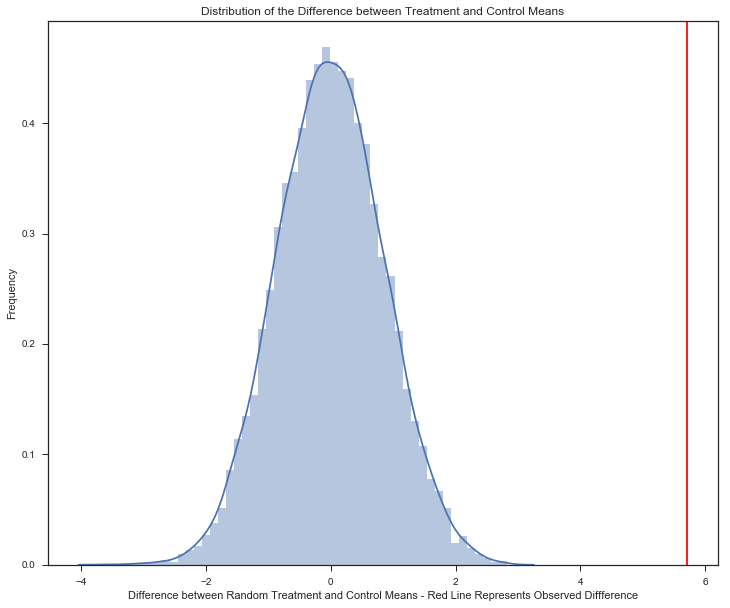

In [37]:
# run 10,000 samples of size 831 from the order_detail table. For each of the 10,000
# trials, calculate the difference in the mean between the 831 chosen, and the remaining
# rows not chosen. The resulting list of 10,000 values is the difference in the means of
# each group for each trial.
# Then create a distribution plot of those sample means and place a red line where the 
# actual mean difference would fall on that distribution.

number_of_trials = 10000
treatment_size = 831
column = 'Quantity'
permutation_list = permutation_samples(order_detail, number_of_trials, treatment_size, column)

fig, ax = plt.subplots(figsize=(12, 10))
sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')

ax.set_title('Distribution of the Difference between Treatment and Control Means')
ax.set_xlabel('Difference between Random Treatment and Control Means - Red Line Represents Observed Diffference')
ax.set_ylabel('Frequency')


In [38]:
# calculate the p-value 
floats = np.array(permutation_list)
count = sum(1 for i in floats if i >= actual_difference)
p_value = count/number_of_trials

print('P-value: {:.12e}'.format(p_value))

P-value: 0.000000000000e+00


Clearly the observed mean difference of the quantity ordered between products with a discount and without a discount is extremely unlikely to be from chance. 

## Conclusion: The null hypothesis is rejected.
###  There is strong evidence that discounts of 5% or more result in product orders of higher quantity.

### But how is the level of discount effecting the quantity ordered? To explore this question I'll begin by doing some additional EDA focused on the difference between the discount groups.

In [39]:
# make a subset of order_detail records for each of the levels of discount. 
# Do some EDA on these three groups.
temp_df = order_detail.loc[order_detail['discount_group'] != [1],['OrderId','discount_group','Quantity', 'line_total']].copy()

temp_1 = temp_df.loc[temp_df['discount_group'] == 1]
temp_2 = temp_df.loc[temp_df['discount_group'] == 2]
temp_3 = temp_df.loc[temp_df['discount_group'] == 3]
temp_4 = temp_df.loc[temp_df['discount_group'] == 4]

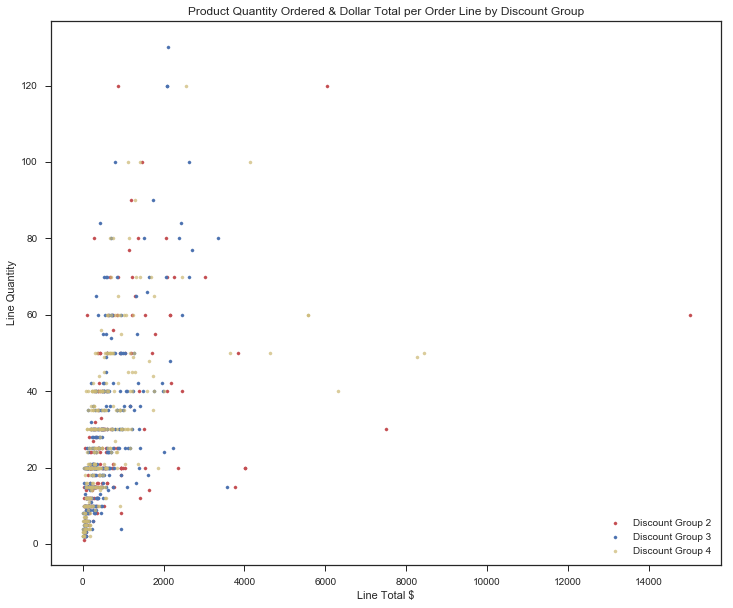

In [40]:
# plot discount groups 2-4, color to indicate discount_group
fig, ax = plt.subplots(figsize=(12, 10))

ax.scatter(temp_2['line_total'], temp_2['Quantity'], s=10, c='r', alpha=1, label='Discount Group 2')
ax.scatter(temp_3['line_total'], temp_3['Quantity'], s=10, c='b', alpha=1, label='Discount Group 3')
ax.scatter(temp_4['line_total'], temp_4['Quantity'], s=10, c='y', alpha=.7, label='Discount Group 4')

ax.set_xlabel("Line Total $")
ax.set_ylabel("Line Quantity")
ax.set_title('Product Quantity Ordered & Dollar Total per Order Line by Discount Group')
plt.legend(loc='lower right')

It appears that order lines in discount group 3 (discounts over 10% but less than 20%) have no occurrances with a line_total of over $4,000.

No other patterns are are visible in this plot. 

Next: Create some boxplots of the same data.

/Users/giovanni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


Text(0.5, 1.0, 'Quantity of Product Ordered by Discount Group')

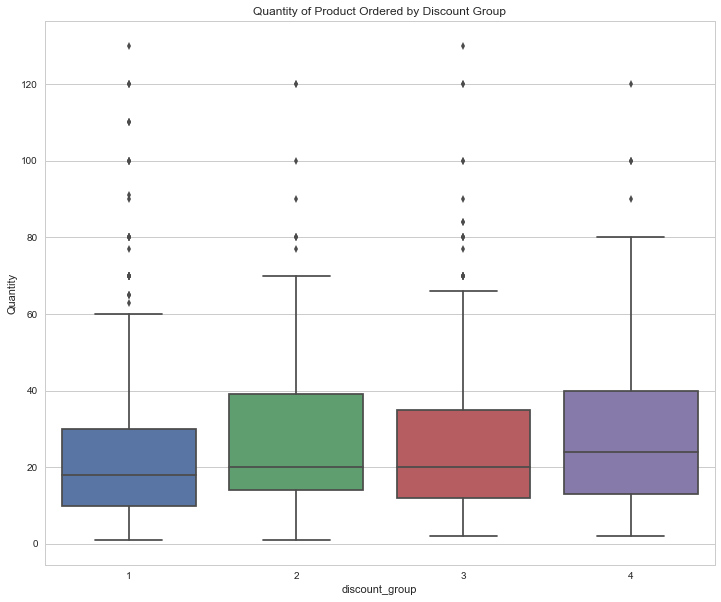

In [41]:
sns.set_style("whitegrid") 

fig, ax = plt.subplots(figsize=(12, 10))

sns.boxplot(x = 'discount_group', y = 'Quantity', data = order_detail)
ax.set_title('Quantity of Product Ordered by Discount Group')

The box plot shows many outliers at the high range of values at every discount level. I will try removing the top 5% of values from all groups.

/Users/giovanni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


Text(0.5, 1.0, 'Quantity of Product Ordered by Discount Group')

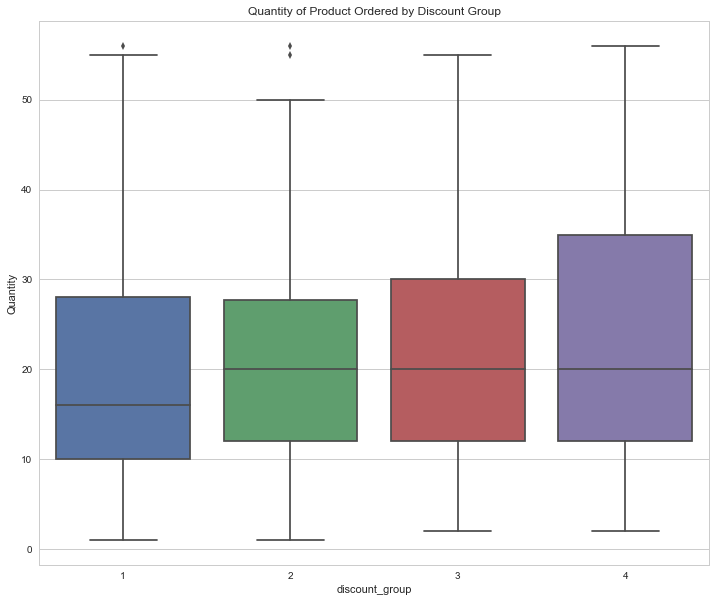

In [42]:
quantile = order_detail['Quantity'].quantile(0.95)
temp_df = order_detail[order_detail['Quantity'] < quantile]

fig, ax = plt.subplots(figsize=(12, 10))

sns.boxplot(x = 'discount_group', y = 'Quantity', data = temp_df)
ax.set_title('Quantity of Product Ordered by Discount Group')

Removing the outliers makes the differences in the middle 50% of the values in each discount group more visible. There is a clear difference for the mean quantity in groups 2-4 as compared to group 1. 

Next: Use violin plots to visualize the differences in another way.

/Users/giovanni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/giovanni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


Text(0.5, 1.0, 'Product Quantity Ordered in each Discount Group')

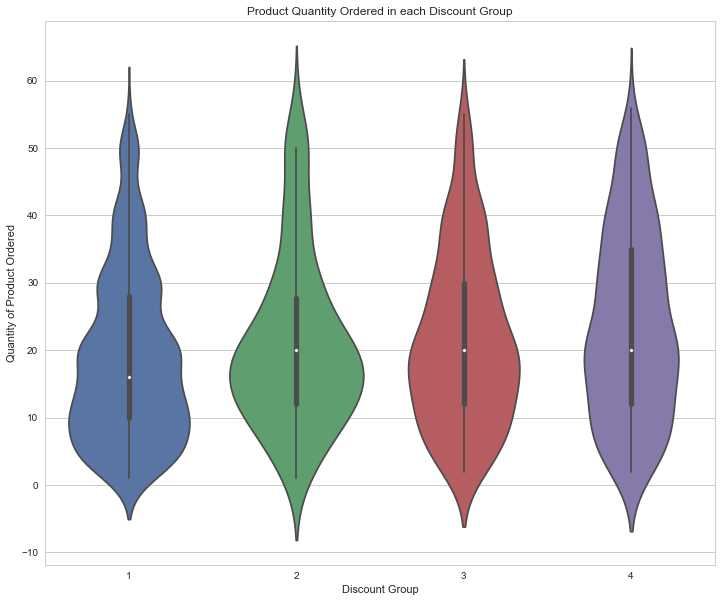

In [43]:
# try a violin plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)

ax = sns.violinplot(x='discount_group', y='Quantity', data=temp_df)
ax.set_xlabel("Discount Group")
ax.set_ylabel("Quantity of Product Ordered")
ax.set_title("Product Quantity Ordered in each Discount Group")


The violin plots show the higher mean of groups 2-4 but also makes it easier to see that the distribution of quantity in discount group 1 is fatter at the lower range. However, the distribution of quantity in discount groups 2-4 is not dramatically different.

## Recomendations:
Given the signifigantly higher values of order quantity when there is a discount of at least 5%, yet no obvious difference between discount levels above 5%, it may be worthwhile to test limiting product discounts to no more than 5%. 

---

## Hypothesis test 2:

### Ho: There is no difference in the dollar amount ordered of products with a discount of 5% or more as compared to with a discount of less than 5%.

### Ha: The mean dollar amount of products ordered with a discount of 5% or more is higher than products ordered with a discount of less than 5%.

In [44]:
# calculate the mean dollar value for a product order when discount is at least 5%
mean_with_discount = np.mean(order_detail[order_detail['Discount'] >= 0.05]['line_total'])
mean_with_discount

619.5021407942237

In [45]:
# calculate the mean dollar value for a product order when the discount is less than 5%
mean_without_discount = np.mean(order_detail[order_detail['Discount'] < 0.05]['line_total'])
mean_without_discount

567.2105441842901

From above, I know there are 831 records in the "discount" group and 1,324 lines in the "no discount" group. After calculating the actual difference between these two groups, I will run another test using permutations to see how likely it is to get the difference observed.

In [46]:
actual_difference = mean_with_discount - mean_without_discount
actual_difference

52.29159660993355

/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Frequency')

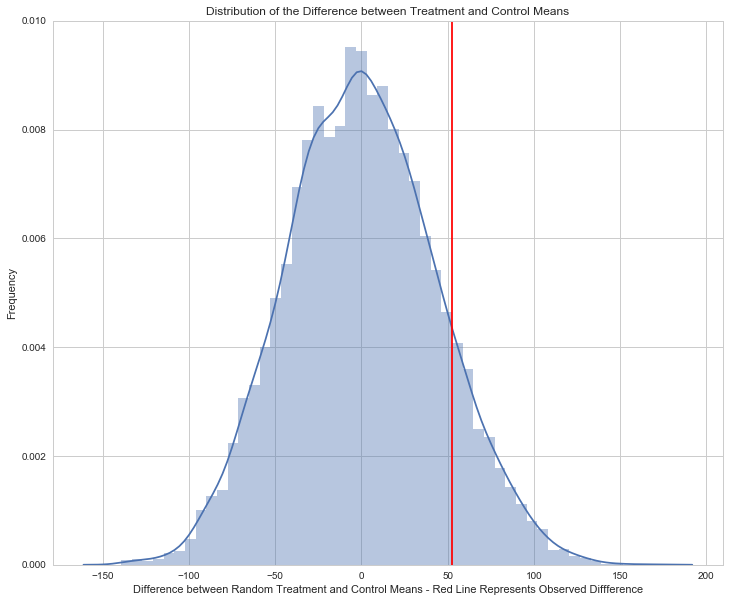

In [47]:
number_of_trials = 10000
treatment_size = 831
column = 'line_total'
permutation_list = permutation_samples(order_detail, number_of_trials, treatment_size, column)

fig, ax = plt.subplots(figsize=(12, 10))

sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')
ax.set_title('Distribution of the Difference between Treatment and Control Means')
ax.set_xlabel('Difference between Random Treatment and Control Means - Red Line Represents Observed Diffference')
ax.set_ylabel('Frequency')

In [48]:
# calculate the p-value
floats = np.array(permutation_list)
count = sum(1 for i in floats if i >= actual_difference)
p_value = count/number_of_trials
p_value

0.1204

Out of 10,000 trials taking random samples of size 831 and then the remaining 1,324 records, then comparing the mean of those two groups: 

12% had a difference of more than 52.29

## Conclusions:

### The null hypothesis cannot be rejected. There is an 12% chance that the difference observed bewteen the "discount" and the "no discount" groups could have been obtained randomly. 

### Recomendations:

### While this test failed the 5% threshold, there may still be a relationship between discounts and higher dollar product orders. Because the data set does not include product costs, I have no way of evaluating how discounts effect profit margins. By using product cost information, further analysis could be done to better understand the financial impact of various levels of discount on each products profitability. 

---

## Hypothesis test 3:

### Ho: There is no difference in the average order dollar amount for "older" customers as compared to the "younger" customers.

### Ha: The average order dollar amount for "older" customers is larger as compared to "younger" customers.

#### In this context, "older" means customers with longer order histories.

To explore this and possible other questions relating to order size and time I added five new columns to the customers table:
    * total number of orders
    * total $ value of all orders
    * first order date
    * last order date
    * average orders/month (year?, etc.)


In [49]:
# add columns to customer dataframe: orders_count, orders_value, first_order_date, last_order_date
customers['orders_count'] = 0
customers['orders_value'] = 0
customers['order_avg'] = 0
customers['first_order_date'] = 0
customers['last_order_date'] = 0

# cast date columns as pandas datetime
customers['first_order_date'] = pd.to_datetime(customers['first_order_date'])
customers['last_order_date'] = pd.to_datetime(customers['last_order_date'])

customers.head()


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,order_avg,first_order_date,last_order_date
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,0,0,0,1970-01-01,1970-01-01
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,0,0,0,1970-01-01,1970-01-01
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,0,0,0,1970-01-01,1970-01-01
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,0,0,0,1970-01-01,1970-01-01
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,0,0,0,1970-01-01,1970-01-01


In [50]:
#get orders count for each customer
orders_count = orders.groupby("CustomerId")["Id"].nunique().copy()
orders_count.head(10)

CustomerId
ALFKI     6
ANATR     4
ANTON     7
AROUT    13
BERGS    18
BLAUS     7
BLONP    11
BOLID     3
BONAP    17
BOTTM    14
Name: Id, dtype: int64

In [51]:
orders_count = orders_count.reset_index()
# orders_count.describe()
orders_count.head(10)

,CustomerId,Id
0,ALFKI,6
1,ANATR,4
2,ANTON,7
3,AROUT,13
4,BERGS,18
5,BLAUS,7
6,BLONP,11
7,BOLID,3
8,BONAP,17
9,BOTTM,14


In [52]:
# rename the Id column to order_count
orders_count.rename(columns={'Id':'order_count'}, inplace=True)
orders_count.head()

,CustomerId,order_count
0,ALFKI,6
1,ANATR,4
2,ANTON,7
3,AROUT,13
4,BERGS,18


In [53]:
# look at the data
orders_count.describe()

,order_count
count,89.000000
mean,9.325843
std,5.810991
min,1.000000
25%,5.000000
50%,8.000000
75%,12.000000
max,31.000000


/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Frequency')

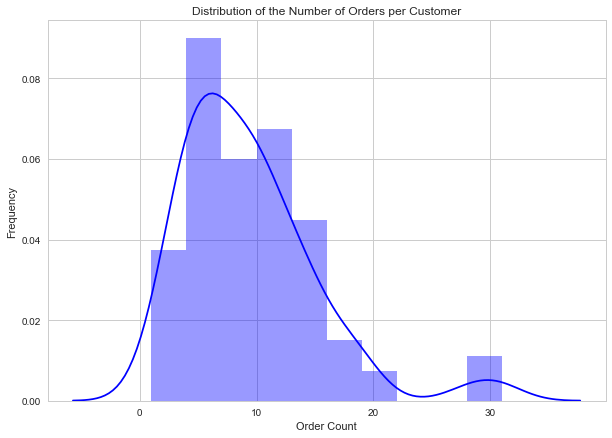

In [54]:
# look at how order_count is distributed
plt.figure(figsize=(10,7))

sns.distplot(orders_count['order_count'], color="blue",)
plt.title("Distribution of the Number of Orders per Customer")
plt.xlabel('Order Count')
plt.ylabel('Frequency')

In [55]:
# add order count to each customer record

for index, row in orders_count.iterrows():
    customer_id = row['CustomerId']
    order_count = row['order_count']
    customer_index = "NONE"
    
    # all customer id's in the customer table had five characters
    # this if/else statement was used initially to identify orders where the customer id was not five digits long
    # after this function identified them, code was added above to correct the errors
    if len(customer_id) == 5:                               
        customer_index = customers.loc[customers['Id'] == customer_id].index
        customers.iloc[customer_index, customers.columns.get_loc('orders_count')] = order_count
    else:
        print('CustomerId: {}'.format(customer_id))
        print('Order Count: {}'.format(order_count))
        print('Customer Index: {}'.format(customer_index))

In [56]:
#calculate customers total value of all orders
orders_total = orders.groupby("CustomerId")['order_total'].agg(sum).copy()

orders_total = orders_total.reset_index()
orders_total.head()

,CustomerId,order_total
0,ALFKI,4273.00
1,ANATR,1402.95
2,ANTON,7023.98
3,AROUT,13390.65
4,BERGS,24927.58


In [57]:
# add the total value of all orders to each customer
for index, row in orders_total.iterrows():
    customer_id = row['CustomerId']
    order_total = row['order_total']
    customer_index = customers.loc[customers['Id'] == customer_id].index
    customers.iloc[customer_index,customers.columns.get_loc('orders_value')] = order_total

In [58]:
customers.head(10)

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,order_avg,first_order_date,last_order_date
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,0,1970-01-01,1970-01-01
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,4,1402.95,0,1970-01-01,1970-01-01
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,7,7023.98,0,1970-01-01,1970-01-01
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,13,13390.65,0,1970-01-01,1970-01-01
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,18,24927.58,0,1970-01-01,1970-01-01
5,BLAUS,Blauer See Delikatessen,Hanna Moos,Sales Representative,Forsterstr. 57,Mannheim,Western Europe,68306,Germany,0621-08460,0621-08924,7,3239.80,0,1970-01-01,1970-01-01
6,BLONP,Blondesddsl père et fils,Frédérique Citeaux,Marketing Manager,"24, place Kléber",Strasbourg,Western Europe,67000,France,88.60.15.31,88.60.15.32,11,18534.08,0,1970-01-01,1970-01-01
7,BOLID,Bólido Comidas preparadas,Martín Sommer,Owner,"C/ Araquil, 67",Madrid,Southern Europe,28023,Spain,(91) 555 22 82,(91) 555 91 99,3,4232.85,0,1970-01-01,1970-01-01
8,BONAP,Bon app,Laurence Lebihan,Owner,"12, rue des Bouchers",Marseille,Western Europe,13008,France,91.24.45.40,91.24.45.41,17,21963.24,0,1970-01-01,1970-01-01
9,BOTTM,Bottom-Dollar Markets,Elizabeth Lincoln,Accounting Manager,23 Tsawassen Blvd.,Tsawassen,North America,T2F 8M4,Canada,(604) 555-4729,(604) 555-3745,14,20801.59,0,1970-01-01,1970-01-01


In [59]:
# look at the data
customers.describe()

,orders_count,orders_value,order_avg
count,91.000000,91.000000,91.0
mean,9.120879,13909.813297,0.0
std,5.908253,20103.531743,0.0
min,0.000000,0.000000,0.0
25%,5.000000,3166.755000,0.0
50%,8.000000,7023.980000,0.0
75%,12.000000,16646.830000,0.0
max,31.000000,110277.320000,0.0


In [60]:
# some customers have no orders
# inspect the count of orders for customers

order_counts = customers.groupby('orders_count')['orders_count'].count()
order_counts

orders_count
0      2
1      1
2      2
3      7
4      6
5     10
6      8
7      7
8      4
9      5
10    11
11     4
12     3
13     3
14     6
15     3
17     1
18     3
19     2
28     1
30     1
31     1
Name: orders_count, dtype: int64

Two customers have no order, one customer has only one order.

In [61]:
# look at these three customers
under_two_orders = customers.loc[customers['orders_count'] < 2]
print (under_two_orders)

       Id                           CompanyName      ContactName  \
12  CENTC            Centro comercial Moctezuma  Francisco Chang   
21  FISSA  FISSA Fabrica Inter. Salchichas S.A.       Diego Roel   
56  PARIS                     Paris spécialités   Marie Bertrand   

          ContactTitle                  Address         City           Region  \
12   Marketing Manager  Sierras de Granada 9993  México D.F.  Central America   
21  Accounting Manager       C/ Moralzarzal, 86       Madrid  Southern Europe   
56               Owner  265, boulevard Charonne        Paris   Western Europe   

   PostalCode Country            Phone              Fax  orders_count  \
12      05022  Mexico     (5) 555-3392     (5) 555-7293             1   
21      28034   Spain   (91) 555 94 44   (91) 555 55 93             0   
56      75012  France  (1) 42.34.22.66  (1) 42.34.22.77             0   

    orders_value  order_avg first_order_date last_order_date  
12         100.8          0       1970-01-01  

In [62]:
#get first and last order dates
# order_dates = orders.groupby("CustomerId")['OrderDate']

for index, row in customers.iterrows():
    #iterrate through customers list
    #set first and last order date variables, cast as time_date
    first_order_date = np.NaN
    last_order_date = np.NaN
    first_order_date = pd.to_datetime(first_order_date)
    last_order_date = pd.to_datetime(last_order_date)

    # get current customer id
    customer_id = row['Id']
    temp_list = []
    # iterrate through orders
    for index, row in orders.iterrows():
        if row['CustomerId'] == customer_id:
            temp_list.append(row['OrderDate'])
#     print(temp_list)
    temp_list.sort()
    customer_index = customers.loc[customers['Id'] == customer_id].index
    
    if len(temp_list) == 0: #flag to see if any customers have no orders
        print('No order found for customer: {}'.format(customer_id))
        
    if len(temp_list) == 1: #handle the case where there is only one order
        print('Customer: {} has only one order.'.format(customer_id))
        temp_date = temp_list.pop(0)
        customers.iloc[customer_index, customers.columns.get_loc('first_order_date')] = temp_date
        customers.iloc[customer_index, customers.columns.get_loc('last_order_date')] = temp_date
        
    if temp_list: # case there there is more than one order
        customers.iloc[customer_index, customers.columns.get_loc('first_order_date')] = temp_list.pop(0)
        customers.iloc[customer_index, customers.columns.get_loc('last_order_date')] = temp_list.pop(-1)
    

Customer: CENTC has only one order.
No order found for customer: FISSA
No order found for customer: PARIS


In [63]:
customers.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,order_avg,first_order_date,last_order_date
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,0,2013-08-25,2014-04-09
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,4,1402.95,0,2012-09-18,2014-03-04
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,7,7023.98,0,2012-11-27,2014-01-28
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,13,13390.65,0,2012-11-15,2014-04-10
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,18,24927.58,0,2012-08-12,2014-03-04


In [64]:
# calculate average value of each customers orders and the age of each customer
# cast date columns as datetime
customers['first_order_date'] = pd.to_datetime(customers['first_order_date'])
customers['last_order_date'] = pd.to_datetime(customers['last_order_date'])

customers['order_avg'] = customers['orders_value'] / customers['orders_count']
today = pd.to_datetime('today')
customers['scaled_customer_age'] = (today - customers['first_order_date']).dt.days

customers.sort_values(['scaled_customer_age'])

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,order_avg,first_order_date,last_order_date,scaled_customer_age
39,LACOR,La corne d'abondance,Daniel Tonini,Sales Representative,"67, avenue de l'Europe",Versailles,Western Europe,78000,France,30.59.84.10,30.59.85.11,4,1992.05,498.012500,2014-01-29,2014-03-24,1934
73,SPECD,Spécialités du monde,Dominique Perrier,Marketing Manager,"25, rue Lauriston",Paris,Western Europe,75016,France,(1) 47.55.60.10,(1) 47.55.60.20,4,2423.35,605.837500,2013-11-12,2014-04-22,2012
25,FRANR,France restauration,Carine Schmitt,Marketing Manager,"54, rue Royale",Nantes,Western Europe,44000,France,40.32.21.21,40.32.21.20,3,3172.16,1057.386667,2013-09-17,2014-03-24,2068
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,712.166667,2013-08-25,2014-04-09,2091
77,THECR,The Cracker Box,Liu Wong,Marketing Assistant,55 Grizzly Peak Rd.,Butte,North America,59801,USA,(406) 555-5834,(406) 555-8083,3,1947.24,649.080000,2013-08-07,2014-04-06,2109
89,WILMK,Wilman Kala,Matti Karttunen,Owner/Marketing Assistant,Keskuskatu 45,Helsinki,Scandinavia,21240,Finland,90-224 8858,90-224 8858,7,3161.35,451.621429,2013-07-30,2014-04-07,2117
44,LETSS,Let's Stop N Shop,Jaime Yorres,Owner,87 Polk St. Suite 5,San Francisco,North America,94117,USA,(415) 555-5938,None,4,3076.47,769.117500,2013-06-25,2014-02-12,2152
81,TRAIH,Trail's Head Gourmet Provisioners,Helvetius Nagy,Sales Associate,722 DaVinci Blvd.,Kirkland,North America,98034,USA,(206) 555-8257,(206) 555-2174,3,1571.20,523.733333,2013-06-19,2014-01-08,2158
49,MAISD,Maison Dewey,Catherine Dewey,Sales Agent,Rue Joseph-Bens 532,Bruxelles,Western Europe,B-1180,Belgium,(02) 201 24 67,(02) 201 24 68,7,9736.07,1390.867143,2013-05-07,2014-04-07,2201
31,GREAL,Great Lakes Food Market,Howard Snyder,Marketing Manager,2732 Baker Blvd.,Eugene,North America,97403,USA,(503) 555-7555,None,11,18507.46,1682.496364,2013-05-06,2014-04-30,2202


In [65]:
# the customers with no order have misleading values for customer age.
# I chose to delete customers with less than 2 orders

customers_temp = customers.loc[customers['orders_count'] > 1].copy()
len(customers_temp)

88

In [66]:
# normalize customer_age
x = customers_temp[['scaled_customer_age']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

customers_temp['scaled_customer_age'] = x_scaled


# https://chrisalbon.com/python/data_wrangling/pandas_normalize_column/

In [67]:
customers_temp.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,order_avg,first_order_date,last_order_date,scaled_customer_age
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,712.166667,2013-08-25,2014-04-09,0.273519
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,4,1402.95,350.737500,2012-09-18,2014-03-04,0.867596
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,7,7023.98,1003.425714,2012-11-27,2014-01-28,0.745645
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,13,13390.65,1030.050000,2012-11-15,2014-04-10,0.766551
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,18,24927.58,1384.865556,2012-08-12,2014-03-04,0.932056


/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'Scaled Customer Age')

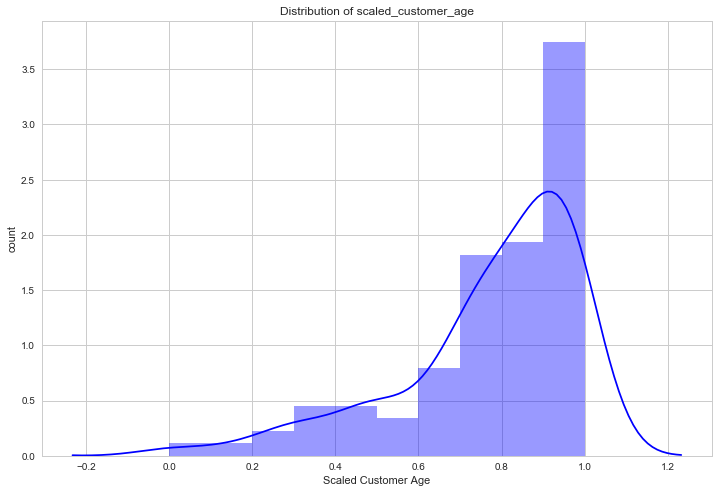

In [68]:
# look at the distribution of customer age
plt.figure(figsize=(12,8))

sns.distplot(customers_temp['scaled_customer_age'], color="blue",)
plt.title("Distribution of scaled_customer_age")
plt.ylabel('count')
plt.xlabel('Scaled Customer Age')

Text(0.5, 0, 'Scaled Customer Age')

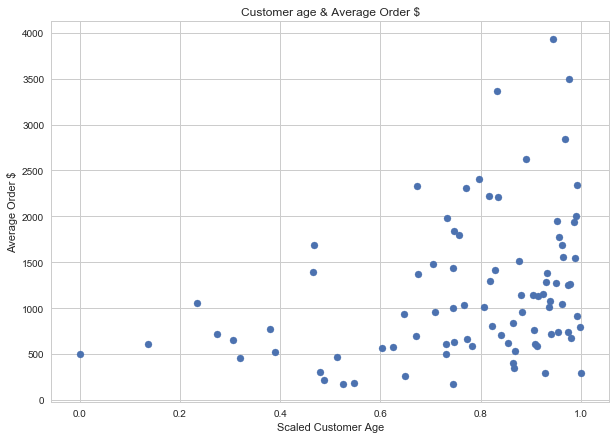

In [69]:
# plot customer age & average $ order
plt.figure(figsize=(10,7))
plt.scatter(customers_temp.scaled_customer_age, customers_temp.order_avg)
plt.title("Customer age & Average Order $")
plt.ylabel('Average Order $')
plt.xlabel('Scaled Customer Age')

There appears to be a correlation between the age of a customer and their average order dollar size. For a hypothesis test, I'll get the average order dollar amount for "older" customers and compare that to "younger" customers. Older and younger are based on how long ago the customer made their first order. I will look at some different slicing points to seperate the two groups.

In [70]:
customers_temp.describe()

,orders_count,orders_value,order_avg,scaled_customer_age
count,88.000000,88.000000,88.000000,88.000000
mean,9.420455,14382.866023,1171.198633,0.773024
std,5.774939,20278.614456,778.224550,0.219084
min,2.000000,357.000000,167.340000,0.000000
25%,5.000000,3330.700000,611.727500,0.698171
50%,8.500000,7112.230000,1005.932857,0.833624
75%,12.000000,17239.690000,1524.212750,0.939460
max,31.000000,110277.320000,3938.475714,1.000000


The oldest 25% of customers (with more than 1 order) have a scaled_customer_age of 0.939460 or greater.

I want a more complete list of percentile values:


In [71]:
customers_temp['scaled_customer_age'].quantile([0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9])

0.0    0.000000
0.1    0.466376
0.2    0.647038
0.3    0.734495
0.4    0.772822
0.5    0.833624
0.6    0.880488
0.7    0.928223
0.8    0.954007
0.9    0.977875
Name: scaled_customer_age, dtype: float64

The oldest 10% of customers have a scaled_customer_age of 0.977875 or more.

In [72]:
customers_temp['oldest_50pct'] = np.where(customers_temp['scaled_customer_age'] >= 0.833624, True, False)
customers_temp['oldest_25pct'] = np.where(customers_temp['scaled_customer_age'] >= 0.939460, True, False)
customers_temp['oldest_10pct'] = np.where(customers_temp['scaled_customer_age'] >= 0.977875, True, False)
customers_temp.sort_values(['scaled_customer_age'])

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,order_avg,first_order_date,last_order_date,scaled_customer_age,oldest_50pct,oldest_25pct,oldest_10pct
39,LACOR,La corne d'abondance,Daniel Tonini,Sales Representative,"67, avenue de l'Europe",Versailles,Western Europe,78000,France,30.59.84.10,30.59.85.11,4,1992.05,498.012500,2014-01-29,2014-03-24,0.000000,False,False,False
73,SPECD,Spécialités du monde,Dominique Perrier,Marketing Manager,"25, rue Lauriston",Paris,Western Europe,75016,France,(1) 47.55.60.10,(1) 47.55.60.20,4,2423.35,605.837500,2013-11-12,2014-04-22,0.135889,False,False,False
25,FRANR,France restauration,Carine Schmitt,Marketing Manager,"54, rue Royale",Nantes,Western Europe,44000,France,40.32.21.21,40.32.21.20,3,3172.16,1057.386667,2013-09-17,2014-03-24,0.233449,False,False,False
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,712.166667,2013-08-25,2014-04-09,0.273519,False,False,False
77,THECR,The Cracker Box,Liu Wong,Marketing Assistant,55 Grizzly Peak Rd.,Butte,North America,59801,USA,(406) 555-5834,(406) 555-8083,3,1947.24,649.080000,2013-08-07,2014-04-06,0.304878,False,False,False
89,WILMK,Wilman Kala,Matti Karttunen,Owner/Marketing Assistant,Keskuskatu 45,Helsinki,Scandinavia,21240,Finland,90-224 8858,90-224 8858,7,3161.35,451.621429,2013-07-30,2014-04-07,0.318815,False,False,False
44,LETSS,Let's Stop N Shop,Jaime Yorres,Owner,87 Polk St. Suite 5,San Francisco,North America,94117,USA,(415) 555-5938,None,4,3076.47,769.117500,2013-06-25,2014-02-12,0.379791,False,False,False
81,TRAIH,Trail's Head Gourmet Provisioners,Helvetius Nagy,Sales Associate,722 DaVinci Blvd.,Kirkland,North America,98034,USA,(206) 555-8257,(206) 555-2174,3,1571.20,523.733333,2013-06-19,2014-01-08,0.390244,False,False,False
49,MAISD,Maison Dewey,Catherine Dewey,Sales Agent,Rue Joseph-Bens 532,Bruxelles,Western Europe,B-1180,Belgium,(02) 201 24 67,(02) 201 24 68,7,9736.07,1390.867143,2013-05-07,2014-04-07,0.465157,False,False,False
31,GREAL,Great Lakes Food Market,Howard Snyder,Marketing Manager,2732 Baker Blvd.,Eugene,North America,97403,USA,(503) 555-7555,None,11,18507.46,1682.496364,2013-05-06,2014-04-30,0.466899,False,False,False


In [73]:
#get count of the oldest 50% of customers
len(customers_temp[customers_temp['oldest_50pct'] == True])

44

In [74]:
#get count of the oldest 25% of customers
len(customers_temp[customers_temp['oldest_25pct'] == True])

22

In [75]:
#get count of the oldest 10% of customers
len(customers_temp[customers_temp['oldest_10pct'] == True])

9

In [76]:
# look at the difference between mean order amounts - splitting customers in half by age
control_mean = np.mean(customers_temp[customers_temp['oldest_50pct'] == False]['order_avg'])
treatment_mean = np.mean(customers_temp[customers_temp['oldest_50pct'] == True]['order_avg'])
actual_difference = treatment_mean - control_mean
print("Treatment mean minus control mean =", actual_difference)

Treatment mean minus control mean = 254.62375428137966


/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Frequency')

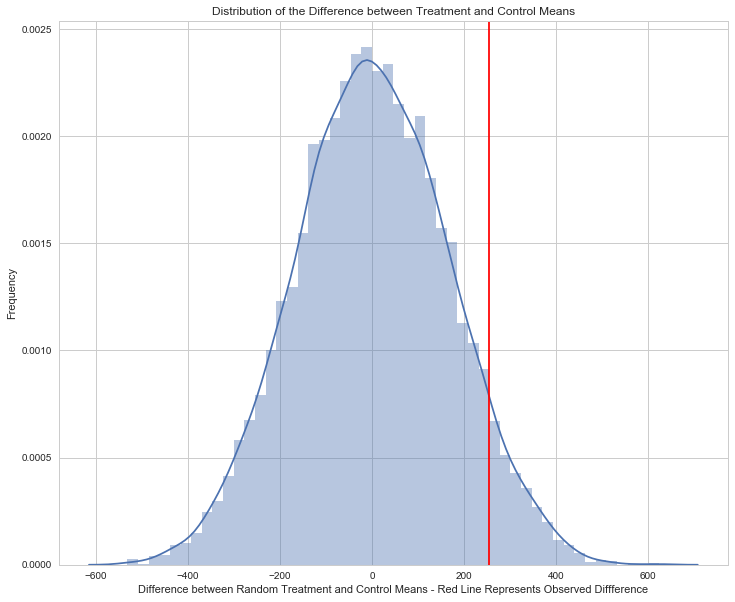

In [77]:
# run the permutation samples function and plot the distribution
number_of_trials = 10000
treatment_size = 44
column = 'order_avg'

permutation_list = permutation_samples(customers_temp, number_of_trials, treatment_size, column)

fig, ax = plt.subplots(figsize=(12, 10))
sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')

ax.set_title('Distribution of the Difference between Treatment and Control Means')
ax.set_xlabel('Difference between Random Treatment and Control Means - Red Line Represents Observed Diffference')
ax.set_ylabel('Frequency')

In [78]:
# calculate p-value
floats = np.array(permutation_list)
count = sum(1 for i in floats if i > 254.62)
p_value = count/10000
print('P-value splitting customers in 1/2 by age:', p_value)

P-value splitting customers in 1/2 by age: 0.0639


In [79]:
# look at the difference between mean order amounts - divide at oldest 25%
control_mean = np.mean(customers_temp[customers_temp['oldest_25pct'] == False]['order_avg'])
treatment_mean = np.mean(customers_temp[customers_temp['oldest_25pct'] == True]['order_avg'])
actual_difference = treatment_mean - control_mean
print("Treatment mean minus control mean =", actual_difference)

Treatment mean minus control mean = 547.0964435542589


/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Frequency')

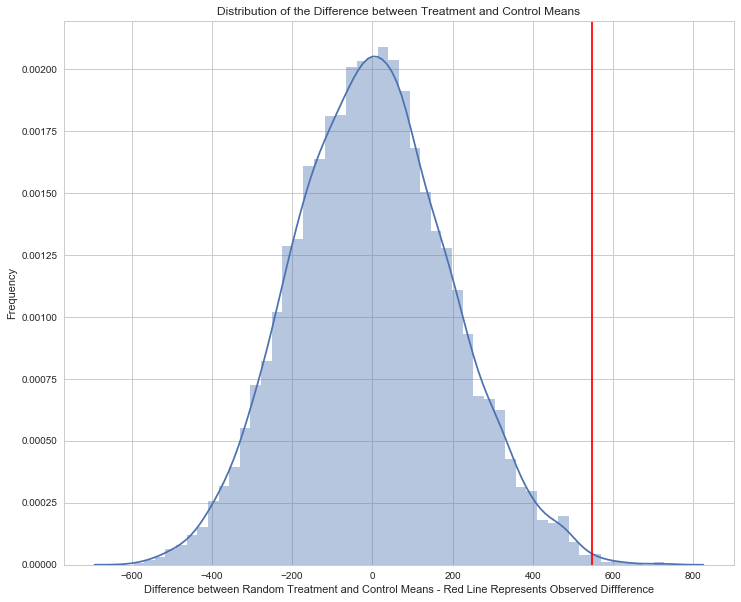

In [80]:
number_of_trials = 10000
treatment_size = 22
column = 'order_avg'

permutation_list = permutation_samples(customers_temp, number_of_trials, treatment_size, column)

fig, ax = plt.subplots(figsize=(12, 10))
sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')

ax.set_title('Distribution of the Difference between Treatment and Control Means')
ax.set_xlabel('Difference between Random Treatment and Control Means - Red Line Represents Observed Diffference')
ax.set_ylabel('Frequency')

In [81]:
# calculate p-value
floats = np.array(permutation_list)
count = sum(1 for i in floats if i > 578.32)
p_value = count/10000
print('P-value when segmenting out oldest 25% of customers:', p_value)

P-value when segmenting out oldest 25% of customers: 0.0012


In [82]:
# look at the difference between mean order amounts - divide at oldest 10%
control_mean = np.mean(customers_temp[customers_temp['oldest_10pct'] == False]['order_avg'])
treatment_mean = np.mean(customers_temp[customers_temp['oldest_10pct'] == True]['order_avg'])
actual_difference = treatment_mean - control_mean
print("Treatment mean minus control mean =", actual_difference)

Treatment mean minus control mean = 153.4968773706928


/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Frequency')

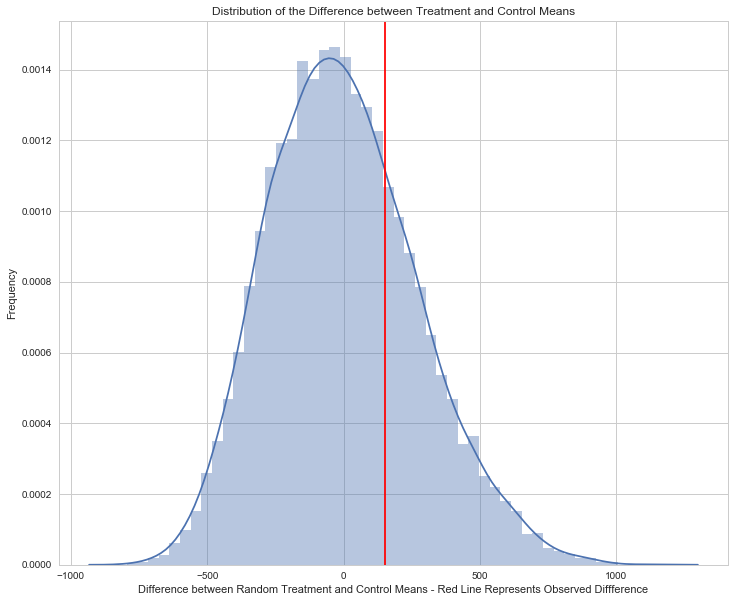

In [83]:
number_of_trials = 10000
treatment_size = 9
column = 'order_avg'

fig, ax = plt.subplots(figsize=(12, 10))
permutation_list = permutation_samples(customers_temp, number_of_trials, treatment_size, column)

sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')

ax.set_title('Distribution of the Difference between Treatment and Control Means')
ax.set_xlabel('Difference between Random Treatment and Control Means - Red Line Represents Observed Diffference')
ax.set_ylabel('Frequency')

In [84]:
# calculate p-value
floats = np.array(permutation_list)
count = sum(1 for i in floats if i > 88.84)
p_value = count/10000
print('P-value when segmemting the oldest 10% of customers:', p_value)

P-value when segmemting the oldest 10% of customers: 0.3519


## Conclusions: Mixed results, requires further analysis.

The probability that the observed difference (or more) in average order amount for each "age" group would be obtained randomly:
* 6.39% for the oldest 50%
* 0.12% for the oldest 25%
* 35.19% for the oldest 10%
 
### With respect to the oldest 25% of customers, there is strong evidence that their average order amount is higher than the youngest 75% of customers. When segmenting the customers in this way the null hypothesis can be rejected.

With respct to the oldest 50% of customers, there is a 6% chance the observed difference was due to chance so the null hypothesis is not rejected. As 6% is very close to the chosen threshold of 5%, and given resluts for the top 25% group, while we cannot reject the null hypothesis there is likely more information to be gleaned by looking more closely at the customers in the 25-50% oldest group. 

Interestingly, when segmenting the oldest 10% of customers from the youngest 90% of customers, the null hypothesis cannot be rejected, despite these customers being included in the oldest 25% group for which there is strong evidence of higher order amounts. There may be customers in this oldest 10% group with some combination of fewer and/or smaller orders. This could be due to numerous factors:
* Do customers stop ordering, or order less, after a certain amount of time?
* Are customers in the oldest 10-25% group receiving special offers that make them order more products than customers in the oldest 10% group?

Many other reasons could account for this anomoly and it should be further explored.

In general it can be concluded that the oldest 25% of customers make larger orders. 

### Recomendations:
### 1. Further analyze the oldest customers, perhaps segmenting them in narrower categories, eg. oldest 10%, oldest 11-15%, oldest 16-20%, etc.
### 2. Explore and test policies that increase customer rentention, such as loyalty programs.

---

## Hypothesis test 4:

### Ho: There is no difference in the average orders per month for the oldest 25% of customers as compared to the youngest 75% of customers.

### Ha: The average orders per month for the oldest 25% of customers is larger as compared to the youngest 75% of customers.

In [85]:
# create a column for orders/month
customers_temp['orders_per_month'] = customers_temp['orders_count'] / ((customers_temp['last_order_date'] - customers_temp['first_order_date']).dt.days/30)
customers_temp.describe()


,orders_count,orders_value,order_avg,scaled_customer_age,orders_per_month
count,88.000000,88.000000,88.000000,88.000000,88.000000
mean,9.420455,14382.866023,1171.198633,0.773024,0.584032
std,5.774939,20278.614456,778.224550,0.219084,0.322120
min,2.000000,357.000000,167.340000,0.000000,0.118577
25%,5.000000,3330.700000,611.727500,0.698171,0.375402
50%,8.500000,7112.230000,1005.932857,0.833624,0.512822
75%,12.000000,17239.690000,1524.212750,0.939460,0.731570
max,31.000000,110277.320000,3938.475714,1.000000,2.222222


In [86]:
# look at the quantiles
customers_temp['orders_per_month'].quantile([0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9])

0.0    0.118577
0.1    0.257522
0.2    0.347561
0.3    0.420067
0.4    0.471213
0.5    0.512822
0.6    0.573265
0.7    0.668599
0.8    0.764858
0.9    0.905396
Name: orders_per_month, dtype: float64

/Users/giovanni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


Text(0.5, 1.0, 'Boxplot of Customers Orders per Month')

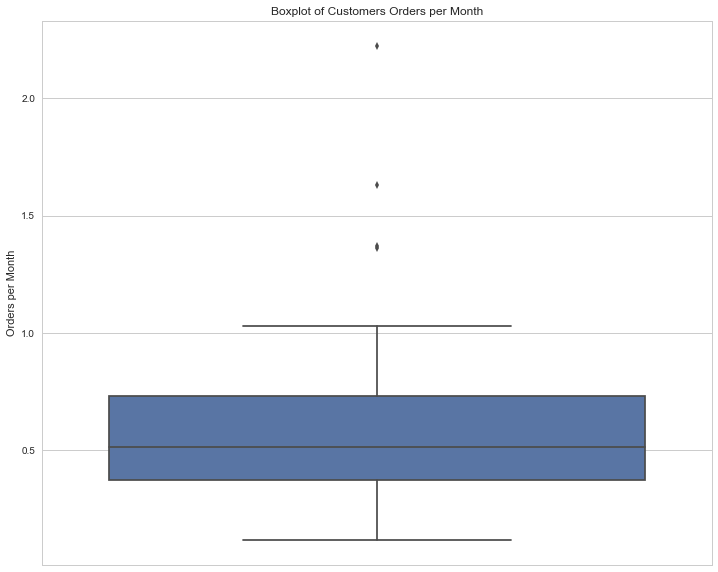

In [87]:
# check a boxplot
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(y = 'orders_per_month', data = customers_temp)
ax.set_ylabel('Orders per Month')
ax.set_title('Boxplot of Customers Orders per Month')

Text(0.5, 1.0, 'Customer Age & Orders per Month')

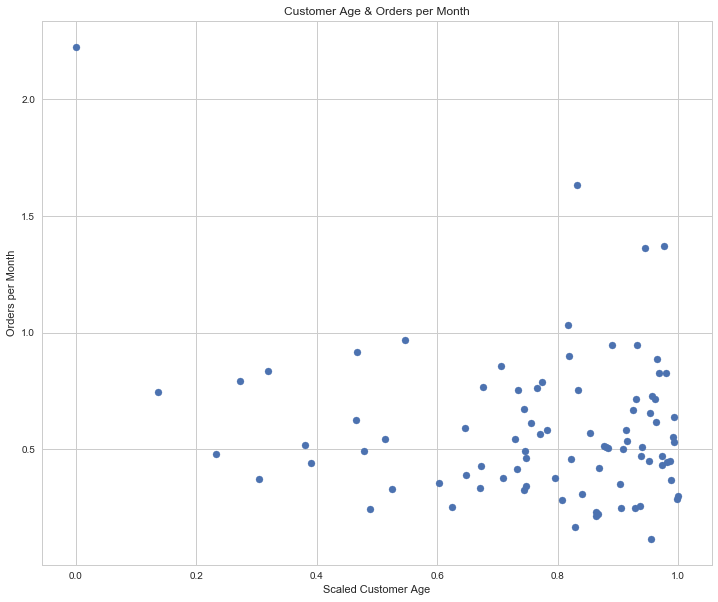

In [88]:
# use a scatter plot to look for the outliers
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(customers_temp.scaled_customer_age, customers_temp.orders_per_month)
ax.set_xlabel('Scaled Customer Age')
ax.set_ylabel('Orders per Month')
ax.set_title('Customer Age & Orders per Month')

/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Frequency')

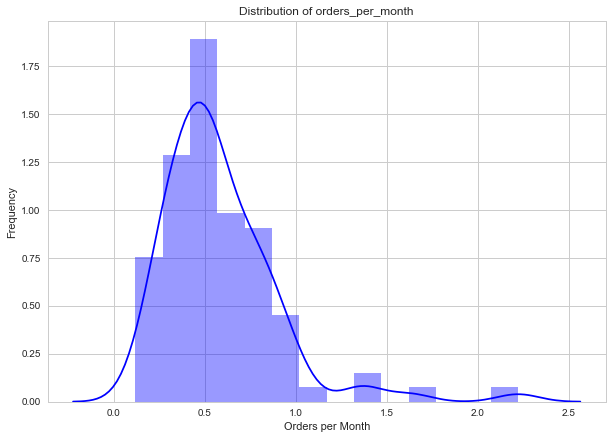

In [89]:
# look at the distribution of customer age
plt.figure(figsize=(10,7))

sns.distplot(customers_temp['orders_per_month'], color="blue",)
plt.title("Distribution of orders_per_month")
plt.xlabel('Orders per Month')
plt.ylabel('Frequency')

In [90]:
# looks like an outlier at 0.00 age and over 2 orders/month
customers_temp.sort_values(['orders_per_month'],ascending=False)

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,...,orders_count,orders_value,order_avg,first_order_date,last_order_date,scaled_customer_age,oldest_50pct,oldest_25pct,oldest_10pct,orders_per_month
39,LACOR,La corne d'abondance,Daniel Tonini,Sales Representative,"67, avenue de l'Europe",Versailles,Western Europe,78000,France,30.59.84.10,...,4,1992.05,498.012500,2014-01-29,2014-03-24,0.000000,False,False,False,2.222222
70,SAVEA,Save-a-lot Markets,Jose Pavarotti,Sales Representative,187 Suffolk Ln.,Boise,North America,83720,USA,(208) 555-8097,...,31,104361.96,3366.514839,2012-10-08,2014-05-01,0.832753,False,False,False,1.631579
19,ERNSH,Ernst Handel,Roland Mendel,Sales Manager,Kirchgasse 6,Graz,Western Europe,8010,Austria,7675-3425,...,30,104874.99,3495.833000,2012-07-17,2014-05-05,0.977352,True,True,False,1.369863
62,QUICK,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,...,28,110277.32,3938.475714,2012-08-05,2014-04-14,0.944251,True,True,False,1.361426
50,MEREP,Mère Paillarde,Jean Fresnière,Marketing Assistant,43 rue St. Laurent,Montréal,North America,H1J 1C3,Canada,(514) 555-8054,...,13,28872.19,2220.937692,2012-10-17,2013-10-30,0.817073,False,False,False,1.031746
42,LAZYK,Lazy K Kountry Store,John Steel,Marketing Manager,12 Orchestra Terrace,Walla Walla,North America,99362,USA,(509) 555-7969,...,2,357.00,178.500000,2013-03-21,2013-05-22,0.547038,False,False,False,0.967742
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,...,18,24927.58,1384.865556,2012-08-12,2014-03-04,0.932056,True,False,False,0.949033
36,HUNGO,Hungry Owl All-Night Grocers,Patricia McKenna,Sales Associate,8 Johnstown Road,Cork,British Isles,None,Ireland,2967 542,...,19,49979.91,2630.521579,2012-09-05,2014-04-30,0.890244,True,False,False,0.946844
31,GREAL,Great Lakes Food Market,Howard Snyder,Marketing Manager,2732 Baker Blvd.,Eugene,North America,97403,USA,(503) 555-7555,...,11,18507.46,1682.496364,2013-05-06,2014-04-30,0.466899,False,False,False,0.919220
8,BONAP,Bon app,Laurence Lebihan,Owner,"12, rue des Bouchers",Marseille,Western Europe,13008,France,91.24.45.40,...,17,21963.24,1291.955294,2012-10-16,2014-05-06,0.818815,False,False,False,0.899471


Text(0.5, 1.0, 'Customer Age & Orders per Month')

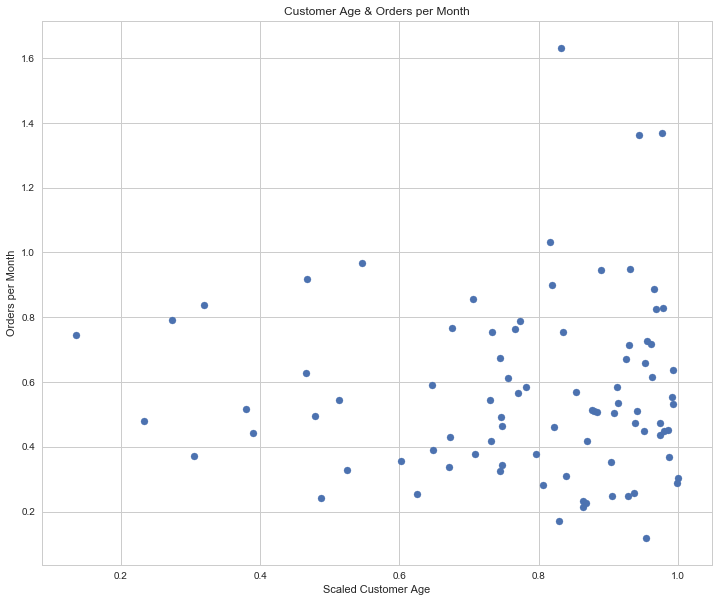

In [91]:
# I decided to drop this customer as a clear outlier. They have 4 orders in less than 2 months.
customers_temp = customers_temp[customers_temp['Id'] != 'LACOR'].copy()

fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(customers_temp.scaled_customer_age, customers_temp.orders_per_month)

ax.set_xlabel('Scaled Customer Age')
ax.set_ylabel('Orders per Month')
ax.set_title('Customer Age & Orders per Month')

In [92]:
# look at the difference between mean order amouts
control_mean = np.mean(customers_temp[customers_temp['oldest_25pct'] == True]['orders_per_month'])
treatment_mean = np.mean(customers_temp[customers_temp['oldest_25pct'] == False]['orders_per_month'])
actual_difference = treatment_mean - control_mean
print("Treatment mean minus control mean =", actual_difference)

Treatment mean minus control mean = -0.06871513574566024


/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Frequency')

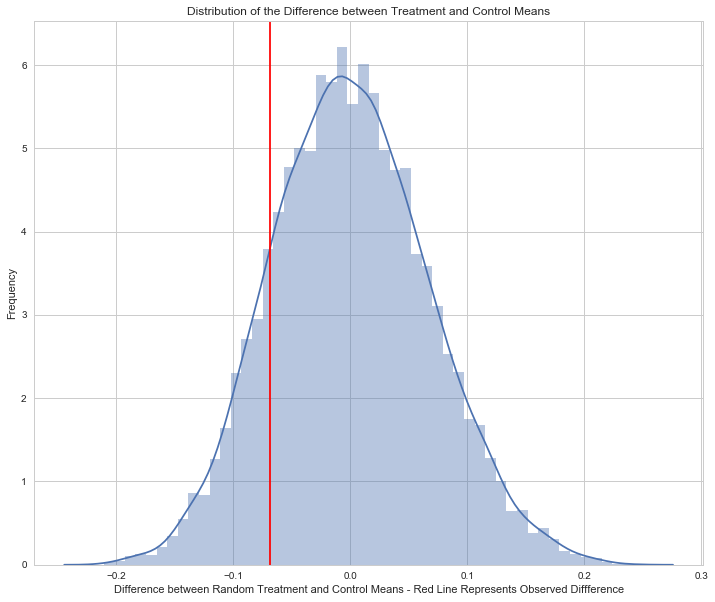

In [93]:
# run permutation samples using the oldest 25% as the treatment group
number_of_trials = 10000
treatment_size = 22
column = 'orders_per_month'

permutation_list = permutation_samples(customers_temp, number_of_trials, treatment_size, column)

fig, ax = plt.subplots(figsize=(12, 10))
sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')

ax.set_title('Distribution of the Difference between Treatment and Control Means')
ax.set_xlabel('Difference between Random Treatment and Control Means - Red Line Represents Observed Diffference')
ax.set_ylabel('Frequency')

In [94]:
# calculate p-value
floats = np.array(permutation_list)
count = sum(1 for i in floats if i > -0.068715)
p_value = count/10000
print('P-value when segmenting out oldest 25% of customers:', p_value)

P-value when segmenting out oldest 25% of customers: 0.8507


## Conclusions:

### The null hypothesis cannot be rejected. There is over an 85% chance that the difference observed bewteen the orders per month for the oldest 25% of customers and the orders per month of the youngest 75% would be obtained by random. 

### Recomendations:

### It appears that the oldest 25% of customers actually have a lower velocity of orders than the youngest 75%. This could be due to many factors and to better understand it would require further analysis. 

---

### Summary of findings

* There is strong evidence that discounts of 5% or more result in larger quantities of product ordered. However, there is insufficient evidence that such discounts result in larger dollar value orders. 
* Insufficient evidence was found to show that discounts of 10% or higher result in larger quantities of product sales when compared to discounts of 5-9%. 
* There is strong evidenct that, in general, customers with a longer order history have higher average order amounts than customers with shorter order histories.
* It appears that, in general customers with a longer order history do not order more frequantly than customers with shorter order histories.

### Summary of recomendations

* It may be useful to restrict discounts of 10% or more to see if 5% is a sufficient discount to increase product quantities ordered.
* Loyalty programs that improve customer retention could be implemented to benefit from the typically larger orders placed by "older" customers.
* 